<a href="https://colab.research.google.com/github/Tykher/AutoML_group_3_AirBnB/blob/main/airbnb_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting the price for airnbnb


## Merging Datasets

In [2]:
import pandas as pd

# List of cities
cities = ['amsterdam', 'athens', 'barcelona', 'berlin', 'budapest', 'lisbon', 'london', 'paris', 'rome', 'vienna']

# Read and concatenate the DataFrames for weekdays and weekends
weekday_dfs = []
weekend_dfs = []

for city in cities:
    weekday_df = pd.read_csv(f'{city}_weekdays.csv')
    weekend_df = pd.read_csv(f'{city}_weekends.csv')

    weekday_df['city'] = city
    weekend_df['city'] = city

    weekday_dfs.append(weekday_df)
    weekend_dfs.append(weekend_df)

# Concatenate the DataFrames
weekday_data = pd.concat(weekday_dfs, ignore_index=True)
weekend_data = pd.concat(weekend_dfs, ignore_index=True)

# Concatenate weekday and weekend data
Complete_Data = pd.concat([weekday_data, weekend_data], axis=0)
# save the dataset into new file
csv_file_path = 'airbnb_full_data.csv'
df = Complete_Data
df.to_csv(csv_file_path, index=False)

## Cleaning Dataset


In [3]:
df = Complete_Data
superhost = df['host_is_superhost'].astype('category').cat.codes
df = df.drop('host_is_superhost', axis=1)
df['host_is_superhost'] = superhost
room_type = df['room_type'].astype('category').cat.codes
df = df.drop('room_type', axis=1)
'''
Entire home/apt - 0
Private room - 1
Shared room - 2
'''
df['room_type'] = room_type
df = df.drop('room_shared', axis=1)
df = df.drop('room_private', axis=1)
df = df.drop('lng', axis=1)
df = df.drop('lat', axis=1)
df = df.drop('attr_index', axis=1)
df = df.drop('rest_index', axis=1)
df = df.drop('rest_index_norm', axis=1)
df = df.drop('attr_index_norm', axis=1)
df = df.drop('Unnamed: 0', axis=1)
df = df.dropna()

numerical_columns = df.select_dtypes(include=['int8', 'int64', 'float64']).columns
df[numerical_columns] = df[numerical_columns].astype('float64')

columns_to_check = ['realSum']

# For each column, calculate Q1 (25th percentile) and Q3 (75th percentile) and the IQR
for column in columns_to_check:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define limits for outliers
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Filter out outliers
    df = df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]
city_to_number = {city: i for i, city in enumerate(df['city'].unique())}
df['city'] = df['city'].map(city_to_number)
print("\nCity to number mapping:")
for city, number in city_to_number.items():
    print(f"{city}: {number}")

'''
City to number mapping:
amsterdam: 0
athens: 1
barcelona: 2
berlin: 3
budapest: 4
lisbon: 5
london: 6
paris: 7
rome: 8
vienna: 9
'''


City to number mapping:
amsterdam: 0
athens: 1
barcelona: 2
berlin: 3
budapest: 4
lisbon: 5
london: 6
paris: 7
rome: 8
vienna: 9


'\nCity to number mapping:\namsterdam: 0\nathens: 1\nbarcelona: 2\nberlin: 3\nbudapest: 4\nlisbon: 5\nlondon: 6\nparis: 7\nrome: 8\nvienna: 9\n'

In [4]:
# save the dataset into new file
csv_file_path = 'airbnb_cleaned_data.csv'
df.to_csv(csv_file_path, index=False)

In [5]:
pd.read_csv(csv_file_path)

,realSum,person_capacity,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,city,host_is_superhost,room_type
0,194.033698,2.0,1.0,0.0,10.0,93.0,1.0,5.022964,2.539380,0,0.0,1.0
1,344.245776,4.0,0.0,0.0,8.0,85.0,1.0,0.488389,0.239404,0,0.0,1.0
2,264.101422,2.0,0.0,1.0,9.0,87.0,1.0,5.748312,3.651621,0,0.0,1.0
3,433.529398,4.0,0.0,1.0,9.0,90.0,2.0,0.384862,0.439876,0,0.0,1.0
4,485.552926,2.0,0.0,0.0,10.0,98.0,1.0,0.544738,0.318693,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
48040,463.501858,5.0,1.0,0.0,10.0,90.0,2.0,1.021878,0.285141,9,0.0,0.0
48041,115.933899,4.0,1.0,0.0,9.0,94.0,1.0,3.041932,0.308192,9,0.0,1.0
48042,304.793960,2.0,0.0,0.0,8.0,86.0,1.0,0.810205,0.100839,9,0.0,0.0
48043,301.054157,2.0,0.0,0.0,10.0,87.0,1.0,3.044100,0.287435,9,0.0,1.0


##Apply ML model


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [7]:
X = df.drop('realSum', axis=1)
y = df['realSum']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((38436, 11), (38436,), (9609, 11), (9609,))

###Choosing the model

In [8]:
# put models in dictionary
models = {"Linear Regression": LinearRegression(),
          "Random Forest Regression": RandomForestRegressor(),
          "Decision Tree Regression": DecisionTreeRegressor(),
          "SVR": svm.SVR(),
          "reg": GradientBoostingRegressor()}

In [9]:
# Create function to evaluate our model

def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))


def show_scores(model):
    preds = model.predict(X_test)
    scores = {"MAE": mean_absolute_error(y_test, preds),
              "RMSLE": rmsle(y_test, preds),
              "R^2": r2_score(y_test, preds)}
    return scores

In [10]:
def fit_models(models, X_train, X_test, y_train, y_test):
  """
  Fits and evaluates given machine learning models.
  models : a dict of different Scikit-Learn machine learning models
  X_train : training data
  X_test : testing data
  y_train : labels assosciated with training data
  y_test : labels assosciated with test data
  """
  np.random.seed(42)
  trained_models={}
  for name, model in models.items():
    trained_models[name] = model.fit(X_train, y_train)
  return trained_models

In [11]:
trained_models = fit_models(models, X_train, X_test, y_train, y_test)

for name, model in trained_models.items():
  print(f"{name}, : {show_scores(model)}")

Linear Regression, : {'MAE': 80.83057099619927, 'RMSLE': 0.45100160248606286, 'R^2': 0.13392645792681435}
Random Forest Regression, : {'MAE': 33.618974818825194, 'RMSLE': 0.2111612100826603, 'R^2': 0.7881896425418302}
Decision Tree Regression, : {'MAE': 33.19074163466524, 'RMSLE': 0.2516250729471165, 'R^2': 0.68219639710466}
SVR, : {'MAE': 83.56309698595167, 'RMSLE': 0.46279967719936654, 'R^2': -0.03737689860423421}
reg, : {'MAE': 52.61043081122584, 'RMSLE': 0.3000100711136408, 'R^2': 0.5938203642576281}


From the observation we can see that Random Forest Regression and Decision Tree Regression performs better than other models. From this two we will choose Random Forest Reggressor since it performs a bit better then Decision Tree. But let's try tune model and also look at the graphics

In [12]:
prediction_models={}
for name, model in trained_models.items():
  prediction_models[name] = model.predict(X_test)

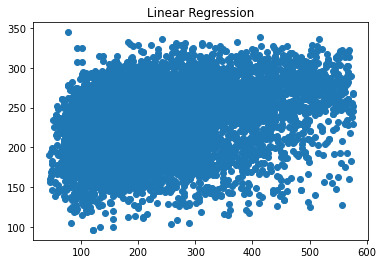

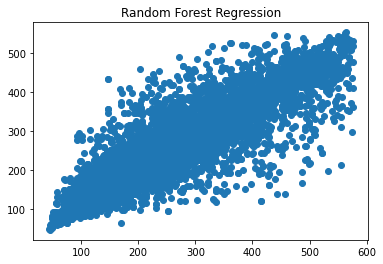

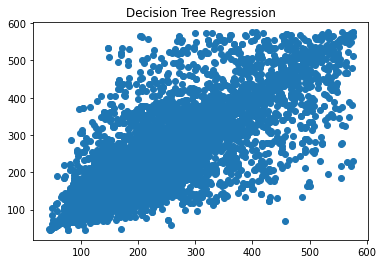

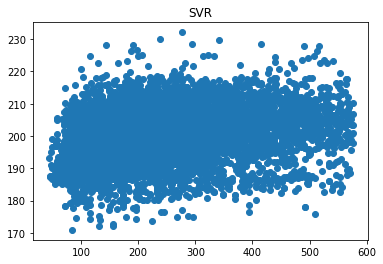

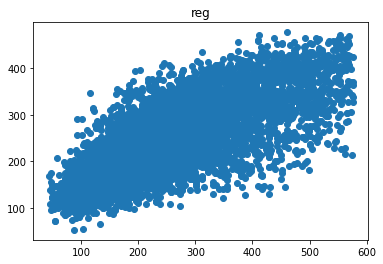

In [13]:
for name, model in prediction_models.items():
  plt.figure()
  plt.title(name)
  plt.scatter(y_test, model)

# Hyperparameter tuning with RandomizedSearchCV


##Tuning the Random  Forest

In [ ]:
# Do not run it!
# It's not useful and takes more than 2 hours

rf_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(),param_distributions=rf_grid,n_iter=20,cv=5,verbose=True)

rs_model.fit(X_train, y_train)
rs_model.best_params_

Best parameters are:

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

Let's check the model

In [14]:
# the best model will be
rf_hyper_model = RandomForestRegressor(n_estimators=1400, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=50, bootstrap=False)
rf_hyper_model.fit(X_train,y_train)
rf_tuned_pred=rf_hyper_model.predict(X_test)

In [15]:
# let's compare with previous model
print(show_scores(rf_hyper_model)), print(show_scores(trained_models["Random Forest Regression"]))

{'MAE': 26.85418899174563, 'RMSLE': 0.20001001641987184, 'R^2': 0.8106993239550271}
{'MAE': 33.618974818825194, 'RMSLE': 0.2111612100826603, 'R^2': 0.7881896425418302}


(None, None)

In [16]:
from joblib import dump, load

In [17]:
model_filename = 'rf_hyper_model.joblib'
dump(rf_hyper_model, model_filename)

['rf_hyper_model.joblib']

In [1]:
import sklearn
print(sklearn.__version__)

1.4.0
